In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import requests
import tensorflow as tf
import string
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, Bidirectional,
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization, GRU)

from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding

import os
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from PIL import Image
from io import BytesIO

In [ ]:
# read data_processed.csv
data_path = '/content/drive/MyDrive/Colab Notebooks/BT5153/Data/'
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BT5153/Data/Data_processed_reduced_v4.csv',encoding= 'unicode_escape')
df.shape

(18680, 11)

In [ ]:
# add img paths
df['img_path'] = df.img_id.apply(lambda x: '/content/drive/MyDrive/Colab Notebooks/BT5153/Data/Pict/' + str(x) + '.jpg')
df.head()

,Unnamed: 0,img_id,title,img_url,description,sex,material,price,brand,colour,Description,img_path
0,0,0,MEN Linen Blended Shorts,https://d15udtvdbbfasl.cloudfront.net/catalog/...,a single layer with a natural feel of natural ...,MEN,"68% Cotton, 32% Linen",29.9,UNIQLO,Color: COL69 NAVY,a single layer with a natural feel of natural ...,/content/drive/MyDrive/Colab Notebooks/BT5153/...
1,1,1,MEN Easy Shorts (Printed),https://d15udtvdbbfasl.cloudfront.net/catalog/...,light and cool shorts are perfect for relaxing...,MEN,100% Cotton,19.9,UNIQLO,Color: COL37 BROWN,light and cool shorts are perfect for relaxing...,/content/drive/MyDrive/Colab Notebooks/BT5153/...
2,2,2,MEN Chino Shorts,https://d15udtvdbbfasl.cloudfront.net/catalog/...,updated to have a relaxed silhouette has a mor...,MEN,100% Cotton,29.9,UNIQLO,Color: COL09 BLACK,updated to have a relaxed silhouette has a mor...,/content/drive/MyDrive/Colab Notebooks/BT5153/...
3,3,3,MEN Uniqlo U Wide Fit Easy Shorts,https://d15udtvdbbfasl.cloudfront.net/catalog/...,shorts inspired by military pants trendy loose...,MEN,100% Cotton,49.9,UNIQLO,Color: COL09 BLACK,shorts inspired by military pants trendy loose...,/content/drive/MyDrive/Colab Notebooks/BT5153/...
4,5,5,MEN Ultra Light Shorts,https://d15udtvdbbfasl.cloudfront.net/catalog/...,kando shorts has been renamed to ultra light s...,MEN,100% Polyester,39.9,UNIQLO,Color: COL32 BEIGE,kando shorts has been renamed to ultra light s...,/content/drive/MyDrive/Colab Notebooks/BT5153/...


In [ ]:
# padding 'ss' and 'ee' to the string to mark the begining and end
df['description'] = df['description'].apply(lambda x: 'ss '+ x + ' ee' )

In [ ]:
#  build vocabulary using glove and vectorize the text
max_tokens = 10000
output_sequence_length=62
vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=output_sequence_length, standardize=None)
text_ds = df.description.values
vectorizer.adapt(text_ds) 
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
index_word = dict(zip(range(len(voc)), voc))
embeddings_index = {}
with open(data_path + "glove.6B.50d.txt") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))
num_tokens = len(voc) 
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 8362 words (560 misses)


In [ ]:
# load image and preprocess to the format compatible to inception_v3
import cv2
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    
    return img

In [ ]:
# define InceptionV3 image feature extraction model 
image_model = tf.keras.applications.InceptionV3(include_top=True,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-2].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
def data_preprocess(feature,text):
  x1,x2,y=[],[],[]
  for i in range(len(feature)):
    for j in range(len(text)-1):
      x1.append(feature)
      x2.append(pad_sequences(np.array([text[:j+1]]).reshape(1,-1),maxlen=output_sequence_length,padding='post',truncating='pre'))
      y.append(to_categorical([text[j+1]], num_classes=num_tokens)[0])
  return x1,x2,y

def batch_process(features,texts):
  x1=[]
  x2=[]
  y=[]
  for i,j in zip(features,texts):
    fe,txt,label = data_preprocess(i,j)
    x1+=fe
    x2+=txt
    y+=label
  return x1,x2,y

In [ ]:
class Generator(tf.keras.utils.Sequence) :
  
  def __init__(self, df, batch_size) :
    self.paths = df.img_path.values
    self.descriptions = df.description.values
    self.batch_size = batch_size  
    self.on_epoch_end()
    
  def __len__(self) :
    return (np.ceil(len(self.paths) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    images = np.array([load_image(path) for path in self.paths[idx * self.batch_size : (idx+1) * self.batch_size]])
    image_features = image_features_extract_model(images)
    image_features = tf.reshape(image_features,
                              (image_features.shape[0], -1,image_features.shape[1]))
    texts = np.array(self.descriptions[idx * self.batch_size : (idx+1) * self.batch_size])
    texts = vectorizer(texts)
    x1,x2,y = batch_process(image_features,texts)
    x1 = tf.convert_to_tensor(x1)
    x1=tf.reshape(x1, (x1.shape[0],x1.shape[2]))
    x2 = tf.convert_to_tensor(x2)
    x2=tf.reshape(x2, (x2.shape[0],x2.shape[2]))
    y = tf.convert_to_tensor(y)
    return [x1,x2], y

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 62)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 62, 50)       446100      input_5[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 50)           102450      input_4[0][0]                    
____________________________________________________________________________________________

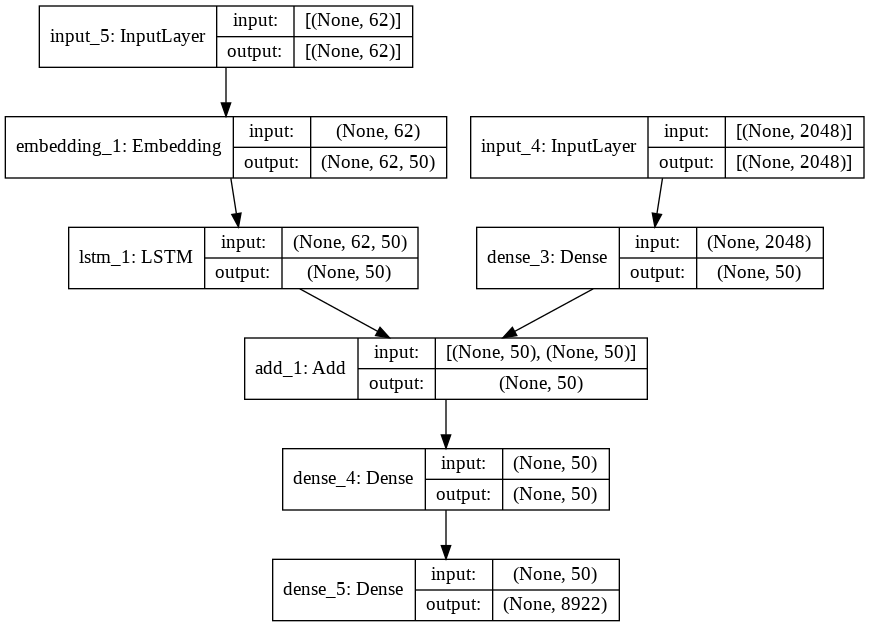

In [ ]:
max_length=62
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, 
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization, GRU)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

with tf.device('/device:CPU:0'):
#with tf.device('/device:GPU:0'):
  OUTPUT_DIM=2048

  embedding_layer = Embedding(num_tokens, embedding_dim, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), trainable=False)

  inputs1 = Input(shape=(OUTPUT_DIM,))
  fe1 = Dense(embedding_dim, activation='relu')(inputs1)
  inputs2 = Input(shape=(max_length,))
  se1 = embedding_layer(inputs2)
  se2 = LSTM(embedding_dim)(se1)
  decoder1 = add([fe1, se2])
  decoder2 = Dense(embedding_dim, activation='relu')(decoder1)
  outputs = Dense(num_tokens, activation='softmax')(decoder2)
  caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  opt = Adam(learning_rate=0.01)

  # Checkpoint
  checkpoint_filepath = '/content/drive/MyDrive/BT5153/Codes/checkpoint_models_lstmv2_zt/checkpoint_models/checkpoint_lstm_zt.ckpt'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_loss',
      mode='min',
      save_best_only=True)

  # Early Stopping
  earlystopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1, restore_best_weights=True, mode='min')

  caption_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

caption_model.summary()
plot_model(caption_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
df_train = df.sample(frac=0.8, random_state=123)
df_validation = df.loc[~df.index.isin(df_train.index)]
df_train = df_train.reset_index()
df_validation = df_validation.reset_index()
print ("train size : ", df_train.shape[0])
print ("validation size : ", df_validation.shape[0])
BATCH_SIZE = 20
train_generator = Generator(df_train, BATCH_SIZE)
validation_generator = Generator(df_validation, BATCH_SIZE)

train size :  14944
validation size :  3736


**Load final trained model**

In [ ]:
# Load weights from 16th epoch
best_checkpoint = '/content/drive/MyDrive/Colab Notebooks/BT5153/Codes/checkpoint_models_lstmv2_zt/lstm_16th_epoch/checkpoint_lstm_zt.ckpt'
caption_model.load_weights(best_checkpoint)

**Generate captions from trained model**

In [ ]:
def generateCaption_beam(photo_url, beam_index):
    photo = load_image(photo_url)
    photo = tf.reshape(photo,(1,photo.shape[0],photo.shape[1],photo.shape[2]))
    photo = image_features_extract_model(photo)

    start = [word_index["ss"]]
    log_prob = 0.0
    start_word = [[start, log_prob]]
    
    while len(start_word[0][0]) < 32:
        temp = []
        for s in start_word:
            sequence = pad_sequences([s[0]], maxlen=max_length, padding='post')
            yhat = caption_model.predict([photo, sequence], verbose = 0)
            yhat = yhat.reshape(-1)
            word_preds = np.argsort(yhat)[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += np.log(yhat[w])
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities (higher log prob, better)
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [index_word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'ee':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

**Compute BLEU scores**

In [ ]:
import time
temp_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/val_lstm_bleu_beam.csv', index_col='img_id')
temp_df = temp_df[temp_df.predicted_caption.isna()]


counter = 1
for id in temp_df.index:
  start = time.time()
  actual_caption = temp_df[temp_df.index == id].real_caption.values[0]
  final_beam = generateCaption_beam(temp_df[temp_df.index == id].img_path.values[0], 2)

  # bleu score
  candidate = final_beam.split()
  reference = actual_caption.split()

  score1 = sentence_bleu([reference], candidate, weights=(1.0,0,0,0), smoothing_function=SmoothingFunction().method4)
  score2 = sentence_bleu([reference], candidate, weights=(0.5,0.5,0,0), smoothing_function=SmoothingFunction().method4)
  score3 = sentence_bleu([reference], candidate, weights=(0.3,0.3,0.3,0), smoothing_function=SmoothingFunction().method4)
  score4 = sentence_bleu([reference], candidate, weights=(0.25,0.25,0.25,0.25), smoothing_function=SmoothingFunction().method4)

  # fill up dataframe
  val_lstm_bleu_beam.loc[id, 'real_caption'] = actual_caption
  val_lstm_bleu_beam.loc[id, 'predicted_caption'] = final_beam
  val_lstm_bleu_beam.loc[id, 'bleu_1'] = score1
  val_lstm_bleu_beam.loc[id, 'bleu_2'] = score2
  val_lstm_bleu_beam.loc[id, 'bleu_3'] = score3
  val_lstm_bleu_beam.loc[id, 'bleu_4'] = score4

  val_lstm_bleu_beam.to_csv('/content/drive/MyDrive/Colab Notebooks/val_lstm_bleu_beam.csv')
  end = time.time()
  print("Processed {}/{}, time elapsed: {:.2f} seconds".format(counter, len(temp_df), end-start))
  counter += 1

Processed 1/3721, time elapsed: 3.74 seconds
Processed 2/3721, time elapsed: 3.69 seconds
Processed 3/3721, time elapsed: 3.79 seconds
Processed 4/3721, time elapsed: 3.69 seconds
Processed 5/3721, time elapsed: 3.50 seconds
Processed 6/3721, time elapsed: 3.86 seconds
Processed 7/3721, time elapsed: 3.87 seconds
Processed 8/3721, time elapsed: 3.70 seconds
Processed 9/3721, time elapsed: 3.74 seconds
Processed 10/3721, time elapsed: 3.58 seconds
Processed 11/3721, time elapsed: 3.49 seconds
Processed 12/3721, time elapsed: 3.32 seconds
Processed 13/3721, time elapsed: 3.78 seconds
Processed 14/3721, time elapsed: 3.73 seconds
Processed 15/3721, time elapsed: 3.72 seconds
Processed 16/3721, time elapsed: 3.34 seconds
Processed 17/3721, time elapsed: 4.15 seconds
Processed 18/3721, time elapsed: 3.55 seconds
Processed 19/3721, time elapsed: 3.55 seconds
Processed 20/3721, time elapsed: 3.67 seconds
Processed 21/3721, time elapsed: 3.34 seconds
Processed 22/3721, time elapsed: 3.68 secon